In [1]:
# Import the necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import cv2 
import scipy.io as sio
import scipy.ndimage
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


In [2]:
input_path = '/home/diya/Projects/super_resolution/flow_super_resolution/dataset/train_data_ml_spatio-temporal_fukami_paper/data_HR/'
output_path = '/home/diya/Projects/super_resolution/flow_super_resolution/dataset/train_data_ml_spatio-temporal_fukami_paper/outputs/fno/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [3]:
# Load high-resolution data generated from MATLAB code
hr_files = sorted(glob.glob('/home/diya/Projects/super_resolution/flow_super_resolution/dataset/train_data_ml_spatio-temporal_fukami_paper/data_HR/matlab_data/data*'))

high_res_data = []
for file in hr_files:
    mat_data = sio.loadmat(file)
    # Extract vorticity field 'omg' as mentioned in the paper
    high_res_data.append(mat_data['omg'])
    
high_res_data = np.array(high_res_data)  # Shape: [n_samples, 128, 128]
print(high_res_data.shape)

(256, 128, 128)


In [5]:
from scipy.ndimage import zoom

def average_downsample(data, target_size=(16, 16)):
    """Perform average downsampling on the input data"""
    n_samples = data.shape[0]
    low_res_data = np.zeros((n_samples, target_size[0], target_size[1]))
    
    for i in range(n_samples):
        # Reshape to perform average pooling
        h, w = data[i].shape
        pool_size = (h // target_size[0], w // target_size[1])
        reshaped = data[i].reshape(target_size[0], pool_size[0], 
                                  target_size[1], pool_size[1])
        low_res_data[i] = reshaped.mean(axis=(1, 3))
    
    return low_res_data

# Generate low-resolution data
low_res_data_8x8 = average_downsample(high_res_data, target_size=(8, 8))
low_res_data_16x16 = average_downsample(high_res_data, target_size=(16,16))
#print(low_res_data_8x8.shape)
print(low_res_data_16x16.shape)

(256, 16, 16)


In [6]:
from sklearn.model_selection import train_test_split

# First split: Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    low_res_data_16x16, high_res_data, test_size=0.2, random_state=42
)

# Second split: Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Check the sizes
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Train: 204, Validation: 26, Test: 26


Using device: cuda
Epoch 0, Batch 0, Loss: 328.022003
Epoch 0, Batch 10, Loss: 234.171875
Epoch 0, Train Loss: 280.725936, Val Loss: 184.767990
Saved model with val loss: 184.767990
Epoch 1, Batch 0, Loss: 203.431366
Epoch 1, Batch 10, Loss: 106.779633


/home/diya/anaconda3/envs/torch_env/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 129.492903, Val Loss: 104.893494
Saved model with val loss: 104.893494
Epoch 2, Batch 0, Loss: 92.102264
Epoch 2, Batch 10, Loss: 90.995308
Epoch 2, Train Loss: 92.837551, Val Loss: 86.949654
Saved model with val loss: 86.949654
Epoch 3, Batch 0, Loss: 91.634705
Epoch 3, Batch 10, Loss: 74.660225
Epoch 3, Train Loss: 81.758438, Val Loss: 75.806824
Saved model with val loss: 75.806824
Epoch 4, Batch 0, Loss: 76.885010
Epoch 4, Batch 10, Loss: 62.720146
Epoch 4, Train Loss: 72.018586, Val Loss: 66.197830
Saved model with val loss: 66.197830
Epoch 5, Batch 0, Loss: 57.988068
Epoch 5, Batch 10, Loss: 67.979156
Epoch 5, Train Loss: 62.347977, Val Loss: 57.311878
Saved model with val loss: 57.311878
Epoch 6, Batch 0, Loss: 57.831573
Epoch 6, Batch 10, Loss: 55.656494
Epoch 6, Train Loss: 54.915313, Val Loss: 52.490374
Saved model with val loss: 52.490374
Epoch 7, Batch 0, Loss: 52.037819
Epoch 7, Batch 10, Loss: 55.526588
Epoch 7, Train Loss: 50.456782, Val Loss: 48.2065

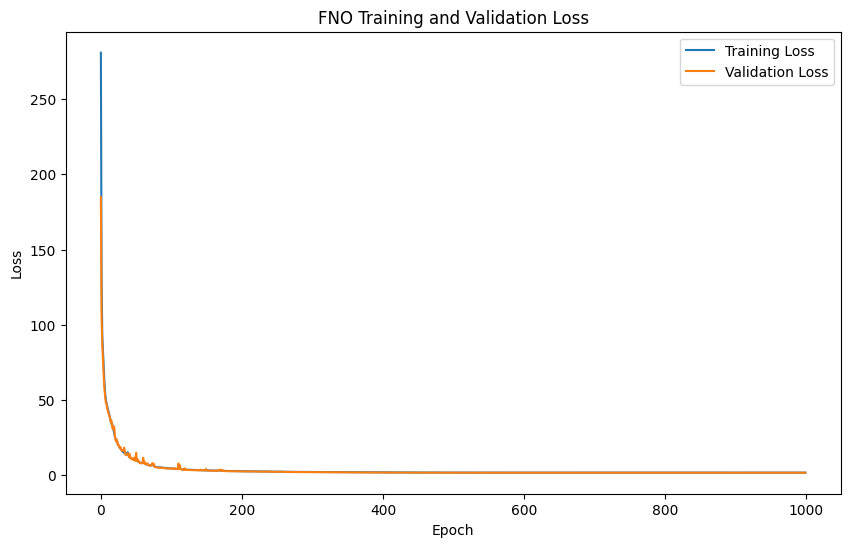

Test Loss: 1.574143
MSE: 1.563935, PSNR: 42.08 dB, NRMSE: 0.008271
Average MSE: 1.563935
Average PSNR: 42.08 dB
Average NRMSE: 0.008271
Sample shapes: (5, 16, 16) (5, 128, 128) (5, 1, 128, 128)


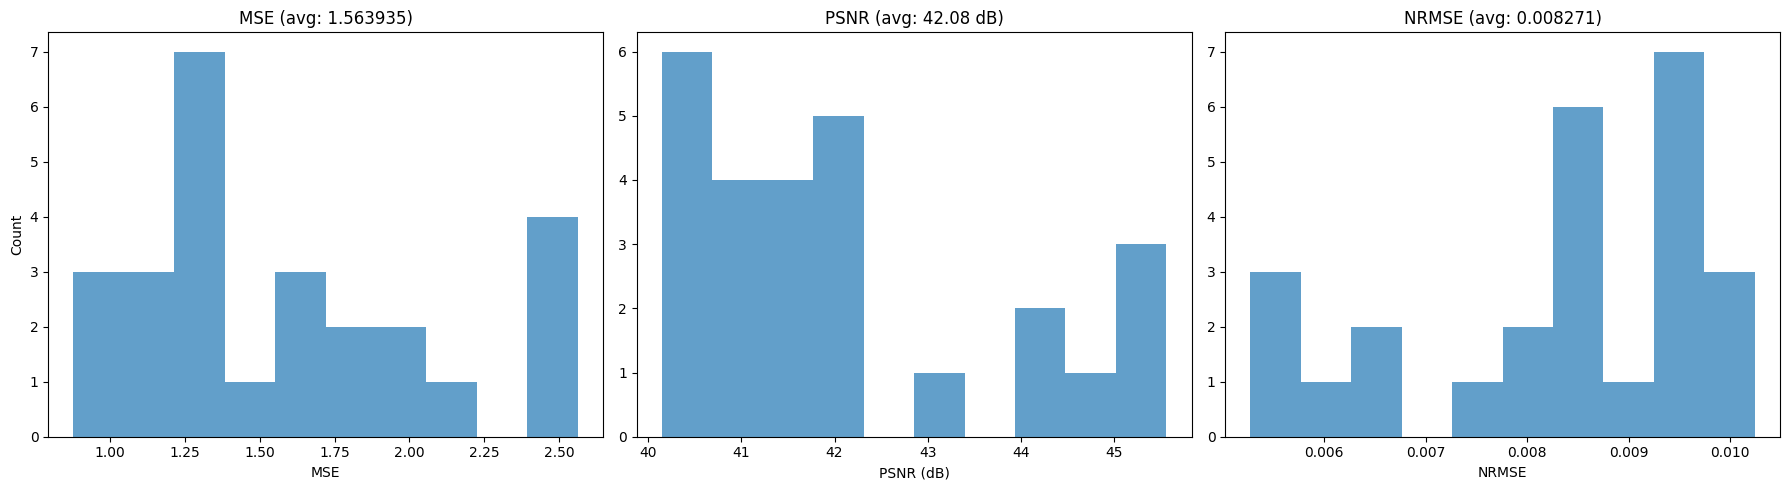

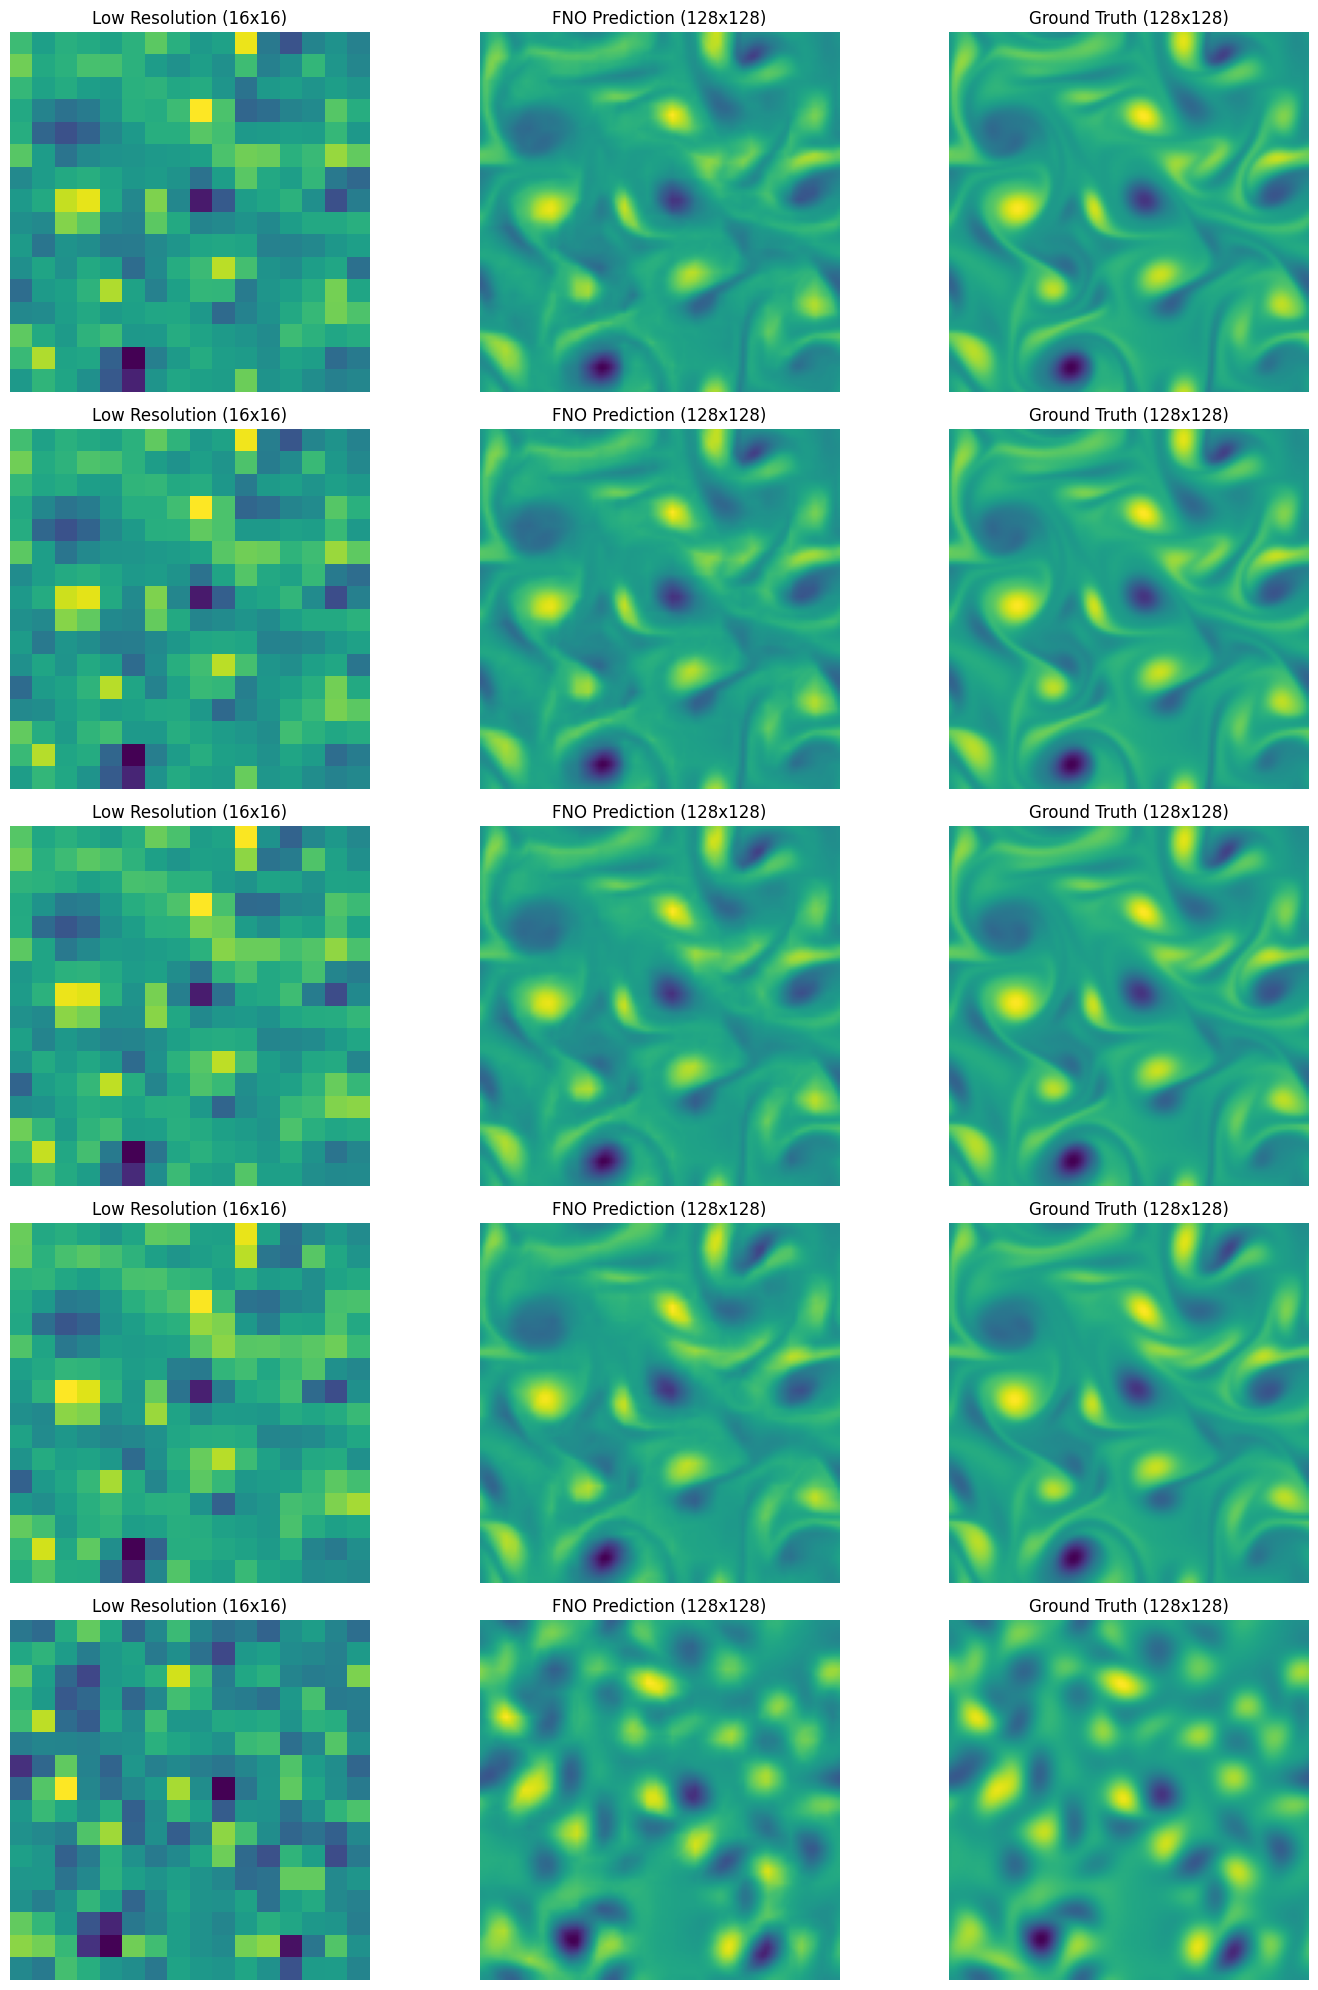

Test Loss: 1.574143
MSE: 1.563935, PSNR: 42.08 dB, NRMSE: 0.008271


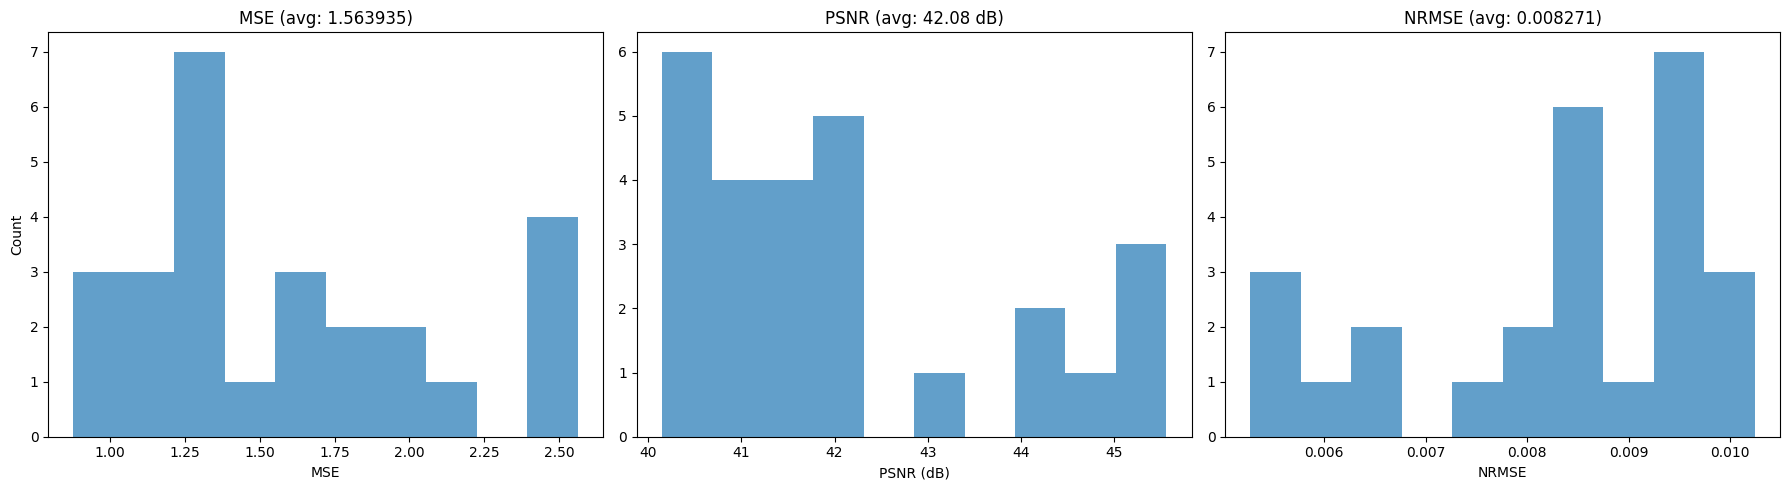

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

class FlowFieldDataset(Dataset):
    def __init__(self, low_res_data, high_res_data=None, transform=None):
        self.low_res_data = torch.tensor(low_res_data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        if high_res_data is not None:
            self.high_res_data = torch.tensor(high_res_data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        else:
            self.high_res_data = None
        self.transform = transform
        
    def __len__(self):
        return len(self.low_res_data)
    
    def __getitem__(self, idx):
        low_res = self.low_res_data[idx]
        
        if self.transform:
            low_res = self.transform(low_res)
            
        if self.high_res_data is not None:
            high_res = self.high_res_data[idx]
            if self.transform:
                high_res = self.transform(high_res)
            return low_res, high_res
        else:
            return low_res


class SpectralConv2d(nn.Module):
    """
    2D Fourier layer. It performs Fourier transform, applies a linear transform in 
    the Fourier space, and then performs inverse Fourier transform.
    """
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes1 = modes1  # modes in the x-direction
        self.modes2 = modes2  # modes in the y-direction
        
        # Complex-valued weights for Fourier space transformation
        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, self.modes1, self.modes2, 2, dtype=torch.float32))
        self.weights2 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, self.modes1, self.modes2, 2, dtype=torch.float32))
    
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x, y), (in_channel, out_channel, x, y) -> (batch, out_channel, x, y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft2(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batch_size, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        # Multiply the relevant Fourier modes
        out_ft[:, :, :self.modes1, :self.modes2] = torch.einsum(
            "bixy,ioxy->boxy",
            x_ft[:, :, :self.modes1, :self.modes2],
            torch.complex(self.weights1[..., 0], self.weights1[..., 1])
        )
        
        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width=64, in_channels=1, out_channels=1, upscale_factor=8):
        super(FNO2d, self).__init__()
        
        self.modes1 = modes1  # Number of Fourier modes in first dimension
        self.modes2 = modes2  # Number of Fourier modes in second dimension
        self.width = width    # Number of channels in hidden layers
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.upscale_factor = upscale_factor
        
        # Input projection
        self.fc0 = nn.Linear(self.in_channels, self.width)
        
        # Fourier layers
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        
        # Regular convolutions for skip connections
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        
        # Batch norms
        self.bn0 = nn.BatchNorm2d(self.width)
        self.bn1 = nn.BatchNorm2d(self.width)
        self.bn2 = nn.BatchNorm2d(self.width)
        self.bn3 = nn.BatchNorm2d(self.width)
        
        # Output projection
        self.fc1 = nn.Linear(self.width, 128)  # Increased width for upscaling
        self.fc2 = nn.Linear(128, self.out_channels)
        
        # Upsampling layers
        self.upsample = nn.Upsample(scale_factor=self.upscale_factor, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        # x shape: [batch, channels, height, width]
        batch_size = x.shape[0]
        
        # Save original spatial dimensions for reshaping
        height, width = x.shape[2], x.shape[3]
        
        # Lift to higher dimensional space
        x = x.permute(0, 2, 3, 1)  # [batch, height, width, channels]
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)  # [batch, width, height, width]
        
        # First Fourier layer
        x1 = self.conv0(x)
        x1 = self.bn0(x1)
        x = self.w0(x)
        x = x + x1
        x = F.gelu(x)
        
        # Second Fourier layer
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x = self.w1(x)
        x = x + x1
        x = F.gelu(x)
        
        # Third Fourier layer
        x1 = self.conv2(x)
        x1 = self.bn2(x1)
        x = self.w2(x)
        x = x + x1
        x = F.gelu(x)
        
        # Fourth Fourier layer
        x1 = self.conv3(x)
        x1 = self.bn3(x1)
        x = self.w3(x)
        x = x + x1
        x = F.gelu(x)
        
        # Upsample to target resolution
        x = self.upsample(x)
        
        # Project back to output space
        x = x.permute(0, 2, 3, 1)  # [batch, height*8, width*8, width]
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = x.permute(0, 3, 1, 2)  # [batch, out_channels, height*8, width*8]
        
        return x


# Training function
def train_fno(model, train_loader, val_loader, optimizer, scheduler, criterion, device, num_epochs=100):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_idx, (low_res, high_res) in enumerate(train_loader):
            low_res, high_res = low_res.to(device), high_res.to(device)
            
            optimizer.zero_grad()
            output = model(low_res)
            loss = criterion(output, high_res)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.6f}')
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for low_res, high_res in val_loader:
                low_res, high_res = low_res.to(device), high_res.to(device)
                output = model(low_res)
                loss = criterion(output, high_res)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        print(f'Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_fno_model.pth')
            print(f'Saved model with val loss: {avg_val_loss:.6f}')
    
    return train_losses, val_losses


# Evaluation function
def evaluate_fno(model, test_loader, device):
    model.eval()
    test_loss = 0.0
    criterion = nn.MSELoss()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for low_res, high_res in test_loader:
            low_res, high_res = low_res.to(device), high_res.to(device)
            output = model(low_res)
            loss = criterion(output, high_res)
            test_loss += loss.item()
            
            # Store predictions and targets for visualization
            all_preds.append(output.cpu().numpy())
            all_targets.append(high_res.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.6f}')
    
    return avg_test_loss, all_preds, all_targets


def visualize_results(low_res, high_res, predictions, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*4))
    
    for i in range(num_samples):
        # Make sure to correctly extract 2D image data
        # For low resolution input (fix the shape issue)
        lr_img = low_res[i].reshape(16, 16)  # Reshape to ensure it's 2D
        axes[i, 0].imshow(lr_img, cmap='viridis')
        axes[i, 0].set_title('Low Resolution (16x16)')
        axes[i, 0].axis('off')
        
        # Predicted high resolution
        pred_img = predictions[i, 0]  # This should already be 2D from the model output
        axes[i, 1].imshow(pred_img, cmap='viridis')
        axes[i, 1].set_title('FNO Prediction (128x128)')
        axes[i, 1].axis('off')
        
        # Ground truth high resolution
        hr_img = high_res[i].reshape(128, 128)  # Reshape to ensure it's 2D
        axes[i, 2].imshow(hr_img, cmap='viridis')
        axes[i, 2].set_title('Ground Truth (128x128)')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('fno_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def calculate_metrics(predictions, targets):
    """
    Calculate MSE, PSNR, and NRMSE for each prediction-target pair.
    
    Args:
        predictions: numpy array of predictions [batch, channel, height, width]
        targets: numpy array of targets [batch, channel, height, width]
        
    Returns:
        Dictionary containing metrics
    """
    # Ensure predictions and targets have the same shape
    assert predictions.shape == targets.shape, "Predictions and targets must have the same shape"
    
    batch_size = predictions.shape[0]
    metrics = {
        'mse': [],
        'psnr': [],
        'nrmse': []
    }
    
    for i in range(batch_size):
        # Get single sample (remove channel dimension if present)
        pred = predictions[i, 0] if predictions.ndim > 3 else predictions[i]
        target = targets[i, 0] if targets.ndim > 3 else targets[i]
        
        # Calculate MSE
        mse = np.mean((pred - target) ** 2)
        metrics['mse'].append(mse)
        
        # Calculate PSNR
        # Handle case where images are identical (MSE=0)
        if mse == 0:
            metrics['psnr'].append(100.0)  # Set to a high value
        else:
            # Normalize data to [0,1] if needed
            data_range = max(target.max() - target.min(), pred.max() - pred.min())
            metrics['psnr'].append(psnr(target, pred, data_range=data_range))
        
        # Calculate NRMSE (Normalized Root Mean Square Error)
        rmse = np.sqrt(mse)
        target_range = target.max() - target.min()
        if target_range == 0:
            nrmse = 0  # Handle division by zero
        else:
            nrmse = rmse / target_range
        metrics['nrmse'].append(nrmse)
    
    return metrics

def save_metrics(metrics, save_dir='metrics'):
    """
    Save metrics to a file and plot them.
    
    Args:
        metrics: Dictionary containing metrics
        save_dir: Directory to save the metrics and plots
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Calculate average metrics
    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
    
    # Save metrics to a text file
    with open(os.path.join(save_dir, 'metrics.txt'), 'w') as f:
        f.write(f"Average MSE: {avg_metrics['mse']:.6f}\n")
        f.write(f"Average PSNR: {avg_metrics['psnr']:.6f} dB\n")
        f.write(f"Average NRMSE: {avg_metrics['nrmse']:.6f}\n")
        
        # Save individual metrics
        f.write("\nIndividual metrics:\n")
        for i in range(len(metrics['mse'])):
            f.write(f"Sample {i}: MSE={metrics['mse'][i]:.6f}, "
                    f"PSNR={metrics['psnr'][i]:.6f} dB, "
                    f"NRMSE={metrics['nrmse'][i]:.6f}\n")
    
    # Plot histograms of metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].hist(metrics['mse'], bins=10, alpha=0.7)
    axes[0].set_title(f'MSE (avg: {avg_metrics["mse"]:.6f})')
    axes[0].set_xlabel('MSE')
    axes[0].set_ylabel('Count')
    
    axes[1].hist(metrics['psnr'], bins=10, alpha=0.7)
    axes[1].set_title(f'PSNR (avg: {avg_metrics["psnr"]:.2f} dB)')
    axes[1].set_xlabel('PSNR (dB)')
    
    axes[2].hist(metrics['nrmse'], bins=10, alpha=0.7)
    axes[2].set_title(f'NRMSE (avg: {avg_metrics["nrmse"]:.6f})')
    axes[2].set_xlabel('NRMSE')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'metrics_distribution.png'), dpi=300)
    
    # Save metrics to numpy files for later use
    np.save(os.path.join(save_dir, 'mse.npy'), np.array(metrics['mse']))
    np.save(os.path.join(save_dir, 'psnr.npy'), np.array(metrics['psnr']))
    np.save(os.path.join(save_dir, 'nrmse.npy'), np.array(metrics['nrmse']))
    
    return avg_metrics

# Example usage in your evaluation function:
def evaluate_fno(model, test_loader, device, save_metrics_dir='metrics'):
    model.eval()
    test_loss = 0.0
    criterion = nn.MSELoss()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for low_res, high_res in test_loader:
            low_res, high_res = low_res.to(device), high_res.to(device)
            output = model(low_res)
            loss = criterion(output, high_res)
            test_loss += loss.item()
            
            # Store predictions and targets for metrics calculation
            all_preds.append(output.cpu().numpy())
            all_targets.append(high_res.cpu().numpy())
    
    # Concatenate batches
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Calculate and save metrics
    metrics = calculate_metrics(all_preds, all_targets)
    avg_metrics = save_metrics(metrics, save_dir=save_metrics_dir)
    
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.6f}')
    print(f'MSE: {avg_metrics["mse"]:.6f}, PSNR: {avg_metrics["psnr"]:.2f} dB, NRMSE: {avg_metrics["nrmse"]:.6f}')
    
    return avg_test_loss, all_preds, all_targets, metrics

# Main execution code
def main():
    # Load the data (assuming the previous code has been run)
    # Data shapes: low_res_data_16x16 [n_samples, 16, 16], high_res_data [n_samples, 128, 128]
    
    # Convert data to PyTorch datasets
    train_dataset = FlowFieldDataset(X_train, y_train)
    val_dataset = FlowFieldDataset(X_val, y_val)
    test_dataset = FlowFieldDataset(X_test, y_test)
    
    # Create data loaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize the FNO model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # For 16x16 to 128x128, we need upscale_factor=8
    modes = 8  # Number of Fourier modes to use
    model = FNO2d(modes1=modes, modes2=modes, width=64, upscale_factor=8).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Train the model
    num_epochs = 1000
    train_losses, val_losses = train_fno(model, train_loader, val_loader, optimizer, scheduler, criterion, device, num_epochs)
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('FNO Training and Validation Loss')
    plt.savefig('fno_training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_fno_model.pth'))
    
    # Evaluate on test set
    test_loss, all_preds, all_targets, metrics = evaluate_fno(model, test_loader, device, save_metrics_dir='fno_metrics')
    print(f"Average MSE: {np.mean(metrics['mse']):.6f}")
    print(f"Average PSNR: {np.mean(metrics['psnr']):.2f} dB")
    print(f"Average NRMSE: {np.mean(metrics['nrmse']):.6f}")
    
    # Visualize results
    sample_idx = np.random.choice(len(test_dataset), size=5, replace=False)
    sample_low_res = X_test[sample_idx]
    sample_high_res = y_test[sample_idx]
    
    # Get predictions for these samples
    sample_tensor = torch.tensor(sample_low_res, dtype=torch.float32).unsqueeze(1).to(device)
    with torch.no_grad():
        sample_preds = model(sample_tensor).cpu().numpy()

    # Make sure dimensions are correct for visualization
    print("Sample shapes:", sample_low_res.shape, sample_high_res.shape, sample_preds.shape)

    # Visualize
    visualize_results(sample_low_res, sample_high_res, sample_preds)
    
    avg_test_loss, test_preds, test_targets, metrics = evaluate_fno(model, test_loader, device)
    
    

if __name__ == "__main__":
    main()